In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 29kB/s 
     |████████████████████████████████| 6.5MB 34.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0+cu92 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
#!pip install opencv-python Google Colab already comes with OpenCV

     |████████████████████████████████| 276kB 7.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=bfaa9bb359b28c0317a889eec49729e013f300c280211840fbf169c4be65ff7a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-vo59y8y2
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-vo59y8y2
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263920 sha256=3d825c0cc3b2be704b77ae2c9ba78f5f76106a01208213e66699353a71fceaef
  Stored in directory: /tmp/pip-ephem-wheel-cache-ujminlnr/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing install

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 6.7MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210511-cp37-none-any.whl size=59498 sha256=4a0ec4030ae1ab3fb479859519bd7ae9f14e3cceaf24455104cf952b75528a73
  Stored in directory: /root/.cache/pip/wheels/10/29/26/aac1434f27f51e56c84401c7f826d5079973e6f5e4c18c8105
Successfully built fvcore


# Data loader

In [ ]:
# import some common libraries
import numpy as np
import argparse
import pickle
import cv2
import random
import os
from google.colab.patches import cv2_imshow # On your local machine you don't need it.
import torch, torchvision
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.transforms as transforms
import detectron2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
%cd /content/drive/Shareddrives/btp-group4/Captioning

/content/drive/Shareddrives/btp-group4/Captioning


In [ ]:
%cd coco/PythonAPI/
!python setup.py build_ext --inplace
!python setup.py build_ext install
%cd ../../

/content/drive/Shareddrives/btp-group4/Captioning/coco/PythonAPI
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/pycocotools/_mask.cpython-37m-x86_64-linux-gnu.so -> pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/__init__.py ->

In [ ]:
# !git clone https://github.com/yunjey/pytorch-tutorial.git
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/
!pip install -r requirements.txt

/content/drive/Shareddrives/btp-group4/Captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Vocabulary Class

In [ ]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

# COCO Dataset and data loader

In [ ]:
!pwd

/content/drive/Shareddrives/btp-group4/Captioning/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
pic=cv2.imread('data/img1.jpg')

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from build_vocab import Vocabulary
from pycocotools.coco import COCO
import cv2

class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        
        # image = Image.open(os.path.join(self.root, path),mode='r').convert('RGB')
        # if self.transform is not None:
        #     image = self.transform(image)
        im = cv2.imread(os.path.join(self.root, path))
        #assert im.shape == (224,224,3)
        im = np.transpose(im,(2,0,1))
        image = torch.tensor(im)
        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
        
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# Hyper Parameters

In [ ]:
model_path='models/test7'
crop_size=224
vocab_path='data/vocab.pkl'
image_dir='data/resized2014'
caption_path='data/annotations/captions_train2014 org.json'
encoder_path='models/encoder-5-3000.pkl'
decoder_path='models/decoder-5-3000.pkl'
log_step=10
save_step=100
embed_size=256
hidden_size=512
num_layers=1
num_epochs=2
batch_size=1
num_workers=2
learning_rate=0.001
pan_threshold = 0.5
load_step = 16000

In [ ]:
import json

In [ ]:
f = open(caption_path,)
data = json.load(f)

In [ ]:
data['annotations']

# Building Models

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(model_path):
        os.makedirs(model_path)

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([transforms.RandomCrop(crop_size),transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build data loader
data_loader = get_loader(image_dir, caption_path, vocab, 
                          transform, batch_size,
                          shuffle=True, num_workers=num_workers) 

# Build the models
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = pan_threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml")
pan_seg_model = DefaultPredictor(cfg)

from detectron2.modeling import build_model
new_full_model = build_model(cfg)
new_full_model.eval()
# im3 = torch.randn(1,3,800,1280)
# im3 = im3.cuda()
type(new_full_model)
# isinstance(new_full_model,detectron2.modeling.meta_arch.GeneralizedRCNN)

# encoder = EncoderCNN(embed_size).to(device)
# decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
# optimizer = torch.optim.Adam(params, lr=learning_rate)



loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


model_final_dbfeb4.pkl: 184MB [00:03, 47.3MB/s]                           


detectron2.modeling.meta_arch.panoptic_fpn.PanopticFPN

# Graph Attention Network

In [ ]:
!pip install dgl
from dgl.nn.pytorch import GATConv
import time

     |████████████████████████████████| 4.4MB 8.5MB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import dgl
# import dgl.function as fn
# from dgl import DGLGraph


# class GATLayer(nn.Module):
#     def __init__(self, g, in_dim, out_dim):
#         super(GATLayer, self).__init__()
#         self.g = g
#         # equation (1)
#         self.fc = nn.Linear(in_dim, out_dim, bias=False)
#         # equation (2)
#         self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
#         self.reset_parameters()

#     def reset_parameters(self):
#         """Reinitialize learnable parameters."""
#         gain = nn.init.calculate_gain('relu')
#         nn.init.xavier_normal_(self.fc.weight, gain=gain)
#         nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

#     def edge_attention(self, edges):
#         # edge UDF for equation (2)
#         z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
#         a = self.attn_fc(z2)
#         return {'e': F.leaky_relu(a)}

#     def message_func(self, edges):
#         # message UDF for equation (3) & (4)
#         return {'z': edges.src['z'], 'e': edges.data['e']}

#     def reduce_func(self, nodes):
#         # reduce UDF for equation (3) & (4)
#         # equation (3)
#         alpha = F.softmax(nodes.mailbox['e'], dim=1)
#         # equation (4)
#         h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
#         return {'h': h}

#     def forward(self, h):
#         # equation (1)
#         z = self.fc(h)
#         self.g.ndata['z'] = z
#         # equation (2)
#         self.g.apply_edges(self.edge_attention)
#         # equation (3) & (4)
#         self.g.update_all(self.message_func, self.reduce_func)
#         return self.g.ndata.pop('h')

In [ ]:
# class MultiHeadGATLayer(nn.Module):
#     def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
#         super(MultiHeadGATLayer, self).__init__()
#         self.heads = nn.ModuleList()
#         for i in range(num_heads):
#             self.heads.append(GATLayer(g, in_dim, out_dim))
#         self.merge = merge

#     def forward(self, h):
#         head_outs = [attn_head(h) for attn_head in self.heads]
#         if self.merge == 'cat':
#             # concat on the output feature dimension (dim=1)
#             return torch.cat(head_outs, dim=1)
#         else:
#             # merge using average
#             return torch.mean(torch.stack(head_outs))

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class GAT(nn.Module):    
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GAT, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W)
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [ ]:
# def build_graph(n):
#     # while the other for destination endpoints.
#     src = list()
#     dst = list()
#     for i in range(n):
#       for j in range(n):
#         src.append(i)
#     for i in range(n):
#       for j in range(n):
#         dst.append(j)
#     # Edges are directional in DGL; Make them bi-directional.
#     u = np.concatenate([src, dst])
#     v = np.concatenate([dst, src])
#     # Construct a DGLGraph
#     return dgl.DGLGraph((u, v))

# Context Gating


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def to_contiguous(tensor):
	if tensor.is_contiguous():
		return tensor
	else:
		return tensor.contiguous()


# gate functiuon
class Gate(nn.Module):
	def __init__(self, seed, source_size, target_size, drop_lm, simple=True):
		super(Gate, self).__init__()
		torch.manual_seed(seed)
		# torch.cuda.manual_seed(seed)
		self.source_size = source_size
		self.middle_size = 2 * self.source_size
		self.target_size = target_size
		self.drop_prob_lm = drop_lm

		if simple:
			self.gate = nn.Sequential(nn.Linear(self.source_size, self.target_size),
									  nn.ReLU(),
									  nn.Dropout(self.drop_prob_lm),
									  )
		else:
			self.gate = nn.Sequential(nn.Linear(self.source_size, self.middle_size),
									  nn.ReLU(),
									  nn.Dropout(self.drop_prob_lm),
									  nn.Linear(self.middle_size, self.target_size),
									  nn.ReLU(),
									  nn.Dropout(self.drop_prob_lm)
									  )

	def forward(self, source, target):
		''' 使用 source 生成 gate 控制 target '''
		gate = self.gate(source)
		new_target = gate * target + target
		# new_target = gate * target
		return new_target


# fusion function
class Fusion(nn.Module):
	''' concate tow features and use MLP to fuse them. '''
	def __init__(self, seed, feat_size1, feat_size2, fusion_size, drop_lm=0.5, activity=None):
		super(Fusion, self).__init__()
		torch.manual_seed(seed)
		torch.cuda.manual_seed(seed)
		self.feat_size1 = feat_size1
		self.feat_size2 = feat_size2
		self.fusion_size = fusion_size
		self.drop_prob_lm = drop_lm
		self.activity = activity

		self.late_fusion = nn.Sequential(nn.Linear(self.feat_size1 + self.feat_size2, self.fusion_size),
										 getattr(nn, self.activity)(),
										 nn.Dropout(self.drop_prob_lm)
										 )

	def forward(self, feats1, feats2, feat_mask=None):  # feats (m ,28, featsize1) feat_mask(m, 28)
		assert feats1.shape[0] == feats2.shape[0] and feats1.shape[1] == feats2.shape[1], 'Size Error: sizes of feats1 and feats2 are not match.'
		feats = to_contiguous(torch.cat([feats1, feats2], -1))  # (m, 28, feat_size+featsize2)
		feats = self.late_fusion(feats)
		return feats


# Train

In [ ]:
from detectron2.layers import ROIAlign

In [ ]:
# g = build_graph(20)

In [ ]:
 net = GAT(12544,200,0.6,0.2,False)

In [ ]:
net_stuff = GAT(12544,200,0.6,0.2,False)

In [ ]:
roi_align = ROIAlign((7,7),1,2)

In [ ]:
lnr = torch.nn.Linear(4000, 128)
lnr_stuff = torch.nn.Linear(2000, 128)
lnr_encoder = torch.nn.Linear(256,128)

In [ ]:
gate_things = Gate(2, 128, 128, 0.2, True)
gate_stuff = Gate(3, 128, 128, 0.2, True)
fusion_var = Fusion(4,128,128,128,0.5,"ReLU")\

gate_things = gate_things.cuda()
gate_stuff = gate_stuff.cuda()
fusion_var = fusion_var.cuda()

In [ ]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [ ]:
encoder.load_state_dict(torch.load(encoder_path))

<All keys matched successfully>

In [ ]:
encoder.eval()

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(net.parameters())+list(lnr.parameters())+list(roi_align.parameters())+list(encoder.linear.parameters()) + list(net_stuff.parameters()) + list(lnr_stuff.parameters()) + list(gate_things.parameters()) + list(gate_stuff.parameters()) + list(fusion_var.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [ ]:
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([transforms.RandomCrop(crop_size),transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
decoder.train()
lnr.train()
lnr_stuff.train()
net.train()
net_stuff.train()
roi_align.train()
gate_things.train()
gate_stuff.train()
fusion_var.train()

Fusion(
  (late_fusion): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
# Train the models
total_step = len(data_loader)
print(total_step)
for epoch in range(num_epochs):
    print("Epoch no: ",epoch+1)
    for iteration, (images, captions, lengths) in enumerate(data_loader):
        # Set mini-batch dataset
        # if i == load_step-1:
        #   load_step = -1
        # if i < load_step:
        #   continue 
        # print(i)
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        # captions= torch.cat([captions,captions],dim=0)
        # targets= torch.cat([targets,targets],dim=0)
        # lengths.append(lengths[0])

        np_img = images[0]

        t=np.array(np_img.cpu())
        img = np.transpose(t,(1,2,0))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(img)

        if transform is not None:
          image = transform(image).unsqueeze(0)
        
        features1 = encoder(image.cuda())
        features1 = lnr_encoder(features1.cpu())

        image=image[0]
        # ----------------------------------detectron prediction --------------------------------------
        np_img = np_img.cpu().numpy()
        np_img = np.transpose(np_img,(1,2,0))
        outputs = pan_seg_model(np_img)

        # ------------------------------------ back bone extraction-----------------------------------
        height, width = image.shape[:2]
        #image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        batched_inputs = [{"image": image, "height": height, "width": width}]

        """
        Normalize, pad and batch the input images.
        """
        from detectron2.structures import ImageList
        images = [x["image"].to(new_full_model.device) for x in batched_inputs]
        images = [(x - new_full_model.pixel_mean) / new_full_model.pixel_std for x in images]
        images = ImageList.from_tensors(images, new_full_model.backbone.size_divisibility)
        features = new_full_model.backbone(images.tensor)

        # extract things features
        #  ----------------------------------------------------------------------
        b=outputs['instances'].pred_boxes
        b1=b.tensor

        n=outputs['instances'].pred_boxes.tensor.shape[0]
        if n==0 or n>20:
          continue
        A=torch.zeros(20,4)
        #c=np.array(outputs['instances'].pred_classes.cpu())
        for k in range(n):
          A[k,:]=b1[k]

        b2=A/4
        b3=A/8
        b4=A/16
        b5=A/32

        n=20

        z = torch.zeros(n,1)
        rois2 = torch.cat((z,b2.cpu()),dim=1)
        rois3 = torch.cat((z,b3.cpu()),dim=1)
        rois4 = torch.cat((z,b4.cpu()),dim=1)
        rois5 = torch.cat((z,b5.cpu()),dim=1)

        rois2=rois2.cuda()
        rois3=rois3.cuda()
        rois4=rois4.cuda()
        rois5=rois5.cuda()

        roi_out2 = roi_align(features["p2"],rois2)
        roi_out3 = roi_align(features["p3"],rois3)
        roi_out4 = roi_align(features["p4"],rois4)
        roi_out5 = roi_align(features["p5"],rois5)

        roi2=roi_out2.reshape((n,12544))
        roi3=roi_out3.reshape((n,12544))
        roi4=roi_out4.reshape((n,12544))
        roi5=roi_out5.reshape((n,12544))

        roi2=roi2+roi3+roi4+roi5
        # ------------------------------------------------------------------------------
        # extract stuff features
        # ------------------------------------------------------------------------------
        b_stuff=[]
        for item in outputs['panoptic_seg'][1]:
          if item['isthing']==False:
            x0,y0=(-1,-1)
            x1,y1=(-1,-1)
            for i in range(outputs['panoptic_seg'][0].shape[0]):
              for j in range(outputs['panoptic_seg'][0].shape[1]-1,0,-1):
                if outputs['panoptic_seg'][0][i][j]==item['id']:
                  if x0==-1:
                    x0,y0=(i,j)
                  x1,y1=(i,j)
            b_stuff.append([x1,y1,x0,y0])       
        b_stuff = torch.tensor(b_stuff)
        # ------------------- roi align to stuff features -------------------------------
        n_stuff = b_stuff.shape[0]
        if n_stuff==0 or n_stuff>10:
          continue
        A_stuff=torch.zeros(10,4)
        #c=np.array(outputs['instances'].pred_classes.cpu())
        for k in range(n_stuff):
          A[k,:]=b_stuff[k]

        b2_stuff=A_stuff/4
        b3_stuff=A_stuff/8
        b4_stuff=A_stuff/16
        b5_stuff=A_stuff/32

        n_stuff=10
        z = torch.zeros(n_stuff,1)
        rois2_stuff = torch.cat((z,b2_stuff.cpu()),dim=1)
        rois3_stuff = torch.cat((z,b3_stuff.cpu()),dim=1)
        rois4_stuff = torch.cat((z,b4_stuff.cpu()),dim=1)
        rois5_stuff = torch.cat((z,b5_stuff.cpu()),dim=1)

        rois2_stuff=rois2_stuff.cuda()
        rois3_stuff=rois3_stuff.cuda()
        rois4_stuff=rois4_stuff.cuda()
        rois5_stuff=rois5_stuff.cuda()

        roi_out2_stuff = roi_align(features["p2"],rois2_stuff)
        roi_out3_stuff = roi_align(features["p3"],rois3_stuff)
        roi_out4_stuff = roi_align(features["p4"],rois4_stuff)
        roi_out5_stuff = roi_align(features["p5"],rois5_stuff)

        roi2_stuff=roi_out2_stuff.reshape((n_stuff,12544))
        roi3_stuff=roi_out3_stuff.reshape((n_stuff,12544))
        roi4_stuff=roi_out4_stuff.reshape((n_stuff,12544))
        roi5_stuff=roi_out5_stuff.reshape((n_stuff,12544))

        roi2_stuff=roi2_stuff+roi3_stuff+roi4_stuff+roi5_stuff

        # --------------------------- graph for things ----------------------------------------------------
        # g.ndata['feat']=roi2.cpu()
        features_things = roi2.cpu()
        
        adj = torch.ones(20,20)
        logits = net(features_things,adj)
        t=logits.flatten()
        t=t.unsqueeze(0)
        # features of things to linear
        features_things=lnr(t)
        features_things=features_things.cuda()
        # ------------------------ pass stuff featurs to graph -----------------------------------------

        features_stuff = roi2_stuff.cpu()
        adj1 = torch.ones(10,10)
        logits_stuff = net_stuff(features_stuff,adj1)
        t_stuff=logits_stuff.flatten()
        t_stuff=t_stuff.unsqueeze(0)
        # features of stuff to linear
        features_stuff=lnr_stuff(t_stuff)
        features_stuff=features_stuff.cuda()
        # gating should be done
                
        features_things_prime = gate_things(features_stuff,features_things)
        features_stuff_prime = gate_stuff(features_things,features_stuff)
        final_res = fusion_var(features_things_prime,features_stuff_prime)
        final_res = final_res.cuda()

        features=torch.cat([final_res,features1.cuda()],dim=1)
        
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        
        decoder.zero_grad()
        lnr.zero_grad()
        lnr_stuff.zero_grad()
        net.zero_grad()
        net_stuff.zero_grad()
        roi_align.zero_grad()
        encoder.zero_grad()
        gate_things.zero_grad()
        gate_stuff.zero_grad()
        fusion_var.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        # Print log info
        if iteration % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, iteration, total_step, loss.item(), np.exp(loss.item()))) 
            
        # Save the model checkpoints
        if (iteration+1) % save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(lnr.state_dict(), os.path.join(
                model_path, 'linear-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(lnr_stuff.state_dict(), os.path.join(
                model_path, 'linear_stuff-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(roi_align.state_dict(), os.path.join(
                model_path, 'roi-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(net.state_dict(), os.path.join(
                model_path, 'net-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(net_stuff.state_dict(), os.path.join(
                model_path, 'net_stuff-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(encoder.state_dict(), os.path.join(
                model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(lnr_encoder.state_dict(), os.path.join(
                model_path, 'linear_encoder-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(gate_things.state_dict(), os.path.join(
                model_path, 'gate_things-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(gate_stuff.state_dict(), os.path.join(
                model_path, 'gate_stuff-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(fusion_var.state_dict(), os.path.join(
                model_path, 'fusion_var-{}-{}.ckpt'.format(epoch+1, iteration+1)))
            torch.save(optimizer.state_dict(), os.path.join(
                model_path, 'optimizer-{}-{}.ckpt'.format(epoch+1, iteration+1)))

221807
Epoch no:  1
Epoch [0/2], Step [10/221807], Loss: 8.7549, Perplexity: 6341.6378
Epoch [0/2], Step [20/221807], Loss: 6.7035, Perplexity: 815.2890
Epoch [0/2], Step [30/221807], Loss: 5.7867, Perplexity: 325.9197
Epoch [0/2], Step [50/221807], Loss: 6.6112, Perplexity: 743.3567
Epoch [0/2], Step [60/221807], Loss: 5.2955, Perplexity: 199.4420
Epoch [0/2], Step [70/221807], Loss: 6.0485, Perplexity: 423.4759
Epoch [0/2], Step [80/221807], Loss: 5.5202, Perplexity: 249.6927
Epoch [0/2], Step [90/221807], Loss: 6.5171, Perplexity: 676.5858
Epoch [0/2], Step [100/221807], Loss: 6.3759, Perplexity: 587.5178
Epoch [0/2], Step [110/221807], Loss: 5.4036, Perplexity: 222.2050
Epoch [0/2], Step [120/221807], Loss: 6.2640, Perplexity: 525.2924
Epoch [0/2], Step [130/221807], Loss: 4.9157, Perplexity: 136.4189
Epoch [0/2], Step [140/221807], Loss: 5.5075, Perplexity: 246.5347
Epoch [0/2], Step [160/221807], Loss: 4.3523, Perplexity: 77.6571
Epoch [0/2], Step [170/221807], Loss: 4.8445, Perp

In [ ]:
features1

In [ ]:
features.shape

torch.Size([1, 346])

In [ ]:
x=torch.randn((1,128))
y=torch.randn((1,128))
z=torch.cat([x,y],dim=1)
z.shape

torch.Size([1, 256])

In [ ]:
captions.shape

torch.Size([2, 12])

In [ ]:
targets.shape

torch.Size([24])

In [ ]:
outputs.shape

torch.Size([30, 9956])

In [ ]:
lengths

[12, 12]

In [ ]:
outputs=pan_seg_model(pic)

In [ ]:
outputs['instances']

In [ ]:
np.array(outputs['instances'].pred_classes.cpu())

In [ ]:
outputs['instances'].pred_boxes.tensor.shape[0]

In [ ]:
b=outputs['instances'].pred_boxes
b1=b.tensor

n=outputs['instances'].pred_boxes.tensor.shape[0]
if n<20:
  x=torch.zeros(20-n,4).cuda()
  b1=torch.cat((b1,x),dim=0)

In [ ]:
b1.shape

#Testing

In [ ]:
net.load_state_dict(torch.load('models/test6/net-1-1000.ckpt'))
net_stuff.load_state_dict(torch.load('models/test6/net_stuff-1-1000.ckpt'))
lnr.load_state_dict(torch.load('models/test6/linear-1-1000.ckpt'))
lnr_stuff.load_state_dict(torch.load('models/test6/linear_stuff-1-1000.ckpt'))
roi_align.load_state_dict(torch.load('models/test6/roi-1-1000.ckpt'))
decoder.load_state_dict(torch.load(decoder_path))
encoder.load_state_dict(torch.load('models/test6/encoder-1-1000.ckpt'))
lnr_encoder.load_state_dict(torch.load('models/test6/linear_encoder-1-1000.ckpt'))
optimizer.load_state_dict(torch.load('models/test6/optimizer-1-1000.ckpt'))
gate_things.load_state_dict(torch.load('models/test6/gate_things-1-1000.ckpt'))
gate_stuff.load_state_dict(torch.load('models/test6/gate_stuff-1-1000.ckpt'))
fusion_var.load_state_dict(torch.load('models/test6/fusion_var-1-1000.ckpt'))

<All keys matched successfully>

In [ ]:
encoder.eval()
decoder.eval()
lnr.eval()
lnr_stuff.eval()
net.eval()
net_stuff.eval()
roi_align.eval()
gate_things.eval()
gate_stuff.eval()
fusion_var.eval()

Fusion(
  (late_fusion): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
im = cv2.imread('data/img4.jpg')
pic = im
pil_image=Image.open('data/img4.jpg')
target_caption="<start> A man playing tennis . <end>"
# if transform is not None:
#     image = transform(pil_image).unsqueeze(0)
# features1 = encoder(image.cuda())
# features1 = lnr_encoder(features1.cpu())

# #assert im.shape == (224,224,3)
im = np.transpose(im,(2,0,1))
np_img = torch.tensor(im)
np_img = np_img.cpu().numpy()
np_img = np.transpose(np_img,(1,2,0))
outputs = pan_seg_model(np_img)

In [ ]:
if transform is not None:
  image = transform(pil_image).unsqueeze(0)

features1 = encoder(image.cuda())
features1 = lnr_encoder(features1.cpu())

image=image[0]
# ------------------------------------ back bone extraction-----------------------------------
height, width = image.shape[:2]
#image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
batched_inputs = [{"image": image, "height": height, "width": width}]

"""
Normalize, pad and batch the input images.
"""
from detectron2.structures import ImageList
images = [x["image"].to(new_full_model.device) for x in batched_inputs]
images = [(x - new_full_model.pixel_mean) / new_full_model.pixel_std for x in images]
images = ImageList.from_tensors(images, new_full_model.backbone.size_divisibility)
features = new_full_model.backbone(images.tensor)

# extract things features
#  ----------------------------------------------------------------------
b=outputs['instances'].pred_boxes
b1=b.tensor

n=outputs['instances'].pred_boxes.tensor.shape[0]
if n==0 or n>20:
  pass
A=torch.zeros(20,4)
#c=np.array(outputs['instances'].pred_classes.cpu())
for k in range(n):
  A[k,:]=b1[k]

b2=A/4
b3=A/8
b4=A/16
b5=A/32

n=20

z = torch.zeros(n,1)
rois2 = torch.cat((z,b2.cpu()),dim=1)
rois3 = torch.cat((z,b3.cpu()),dim=1)
rois4 = torch.cat((z,b4.cpu()),dim=1)
rois5 = torch.cat((z,b5.cpu()),dim=1)

rois2=rois2.cuda()
rois3=rois3.cuda()
rois4=rois4.cuda()
rois5=rois5.cuda()

roi_out2 = roi_align(features["p2"],rois2)
roi_out3 = roi_align(features["p3"],rois3)
roi_out4 = roi_align(features["p4"],rois4)
roi_out5 = roi_align(features["p5"],rois5)

roi2=roi_out2.reshape((n,12544))
roi3=roi_out3.reshape((n,12544))
roi4=roi_out4.reshape((n,12544))
roi5=roi_out5.reshape((n,12544))

roi2=roi2+roi3+roi4+roi5
# ------------------------------------------------------------------------------
# extract stuff features
# ------------------------------------------------------------------------------
b_stuff=[]
for item in outputs['panoptic_seg'][1]:
  if item['isthing']==False:
    x0,y0=(-1,-1)
    x1,y1=(-1,-1)
    for i in range(outputs['panoptic_seg'][0].shape[0]):
      for j in range(outputs['panoptic_seg'][0].shape[1]-1,0,-1):
        if outputs['panoptic_seg'][0][i][j]==item['id']:
          if x0==-1:
            x0,y0=(i,j)
          x1,y1=(i,j)
    b_stuff.append([x1,y1,x0,y0])       
b_stuff = torch.tensor(b_stuff)
# ------------------- roi align to stuff features -------------------------------
n_stuff = b_stuff.shape[0]
if n_stuff==0 or n_stuff>10:
  pass
A_stuff=torch.zeros(10,4)
#c=np.array(outputs['instances'].pred_classes.cpu())
for k in range(n_stuff):
  A[k,:]=b_stuff[k]

b2_stuff=A_stuff/4
b3_stuff=A_stuff/8
b4_stuff=A_stuff/16
b5_stuff=A_stuff/32

n_stuff=10
z = torch.zeros(n_stuff,1)
rois2_stuff = torch.cat((z,b2_stuff.cpu()),dim=1)
rois3_stuff = torch.cat((z,b3_stuff.cpu()),dim=1)
rois4_stuff = torch.cat((z,b4_stuff.cpu()),dim=1)
rois5_stuff = torch.cat((z,b5_stuff.cpu()),dim=1)

rois2_stuff=rois2_stuff.cuda()
rois3_stuff=rois3_stuff.cuda()
rois4_stuff=rois4_stuff.cuda()
rois5_stuff=rois5_stuff.cuda()

roi_out2_stuff = roi_align(features["p2"],rois2_stuff)
roi_out3_stuff = roi_align(features["p3"],rois3_stuff)
roi_out4_stuff = roi_align(features["p4"],rois4_stuff)
roi_out5_stuff = roi_align(features["p5"],rois5_stuff)

roi2_stuff=roi_out2_stuff.reshape((n_stuff,12544))
roi3_stuff=roi_out3_stuff.reshape((n_stuff,12544))
roi4_stuff=roi_out4_stuff.reshape((n_stuff,12544))
roi5_stuff=roi_out5_stuff.reshape((n_stuff,12544))

roi2_stuff=roi2_stuff+roi3_stuff+roi4_stuff+roi5_stuff

# --------------------------- graph for things ----------------------------------------------------
# g.ndata['feat']=roi2.cpu()
features_things = roi2.cpu()

adj = torch.ones(20,20)
logits = net(features_things,adj)
t=logits.flatten()
t=t.unsqueeze(0)
# features of things to linear
features_things=lnr(t)
features_things=features_things.cuda()
# ------------------------ pass stuff featurs to graph -----------------------------------------

features_stuff = roi2_stuff.cpu()
adj1 = torch.ones(10,10)
logits_stuff = net_stuff(features_stuff,adj1)
t_stuff=logits_stuff.flatten()
t_stuff=t_stuff.unsqueeze(0)
# features of stuff to linear
features_stuff=lnr_stuff(t_stuff)
features_stuff=features_stuff.cuda()
# gating should be done
        
features_things_prime = gate_things(features_stuff,features_things)
features_stuff_prime = gate_stuff(features_things,features_stuff)
final_res = fusion_var(features_things_prime,features_stuff_prime)
final_res = final_res.cuda()

features=torch.cat([final_res,features1.cuda()],dim=1)


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU SCORE:0.21470779802151024
Target Caption:<start> A man playing tennis . <end>
Predicted Caption:standing bowl full of green and white . <end>


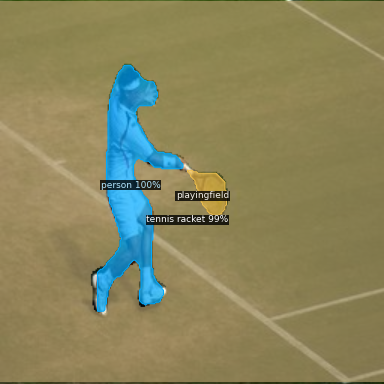

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
sampled_ids = decoder.sample(features)        # (1, max_seq_length) -> (max_seq_length)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)
# sentence=" . <end>"
sampled_caption=[sampled_caption]
# Print out the image and the generated caption
print('BLEU SCORE:'+ str(sentence_bleu(sampled_caption,target_caption.split(' '),weights=(1,0,0,0))))
print('Target Caption:'+ target_caption)
print('Predicted Caption:'+sentence)
v = Visualizer(np_img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
v = v.draw_panoptic_seg_predictions(outputs['panoptic_seg'][0].cpu(),outputs['panoptic_seg'][1])
# v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image())

#Model Summary

In [ ]:
from torchsummary import summary

In [ ]:
print(net)

GAT(
  (leakyrelu): LeakyReLU(negative_slope=0.2)
)


In [ ]:
print(decoder)

DecoderRNN(
  (embed): Embedding(9956, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9956, bias=True)
)


In [ ]:
print(fusion_var)

Fusion(
  (late_fusion): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
)


In [ ]:
print(gate_stuff)

Gate(
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
)


In [ ]:
print(gate_things)

Gate(
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
)


In [ ]:
for name, param in net.named_parameters():
    print(name, '\tWeights=',param.data.shape , '\tParameters=',param.nelement())

W 	Weights= torch.Size([12544, 200]) 	Parameters= 2508800
a 	Weights= torch.Size([400, 1]) 	Parameters= 400


In [ ]:
print(decoder)

DecoderRNN(
  (embed): Embedding(9956, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9956, bias=True)
)


In [ ]:
for name, param in decoder.named_parameters():
    print(name, '\tWeights=',param.data.shape , '\tParameters=',param.nelement())

embed.weight 	Weights= torch.Size([9956, 256]) 	Parameters= 2548736
lstm.weight_ih_l0 	Weights= torch.Size([2048, 256]) 	Parameters= 524288
lstm.weight_hh_l0 	Weights= torch.Size([2048, 512]) 	Parameters= 1048576
lstm.bias_ih_l0 	Weights= torch.Size([2048]) 	Parameters= 2048
lstm.bias_hh_l0 	Weights= torch.Size([2048]) 	Parameters= 2048
linear.weight 	Weights= torch.Size([9956, 512]) 	Parameters= 5097472
linear.bias 	Weights= torch.Size([9956]) 	Parameters= 9956


In [ ]:
for name, param in fusion_var.named_parameters():
    print(name, '\tWeights=',param.data.shape , '\tParameters=',param.nelement())

late_fusion.0.weight 	Weights= torch.Size([128, 256]) 	Parameters= 32768
late_fusion.0.bias 	Weights= torch.Size([128]) 	Parameters= 128


In [ ]:
print(roi_align)

ROIAlign(output_size=(7, 7), spatial_scale=1, sampling_ratio=2, aligned=True)


In [ ]:
for name, param in roi_align.named_parameters():
    print(name, '\tWeights=',param.data.shape , '\tParameters=',param.nelement())

In [ ]:
print(lnr)

Linear(in_features=4000, out_features=256, bias=True)


In [ ]:
for name, param in lnr.named_parameters():
    print(name, '\tWeights=',param.data.shape , '\tParameters=',param.nelement())

weight 	Weights= torch.Size([256, 4000]) 	Parameters= 1024000
bias 	Weights= torch.Size([256]) 	Parameters= 256


In [ ]:
x="I am Romit"
y="I used to be Romit"
sentence_bleu(sampled_caption,target_caption.split(' '))

0

In [ ]:
sampled_caption

[['up',
  'a',
  'close',
  'up',
  'of',
  'a',
  'red',
  'and',
  'white',
  'photo',
  '.',
  '<end>']]